In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
current_dir = os.getcwd()
file_path = os.path.join(os.path.dirname(current_dir), "data", "raw", "covid19-dataset", "Covid Data.csv")
df = pd.read_csv(file_path)

In [3]:
df['DIED'] = [2 if i=='9999-99-99' else 1 for i in df.DATE_DIED]
df.loc[df.SEX==2,'PREGNANT']=2
df.loc[df.PATIENT_TYPE==1,'ICU']=2
df.loc[df.PATIENT_TYPE==1,'INTUBED']=2
for col in df.columns.drop('AGE'):
    for i in [97,98, 99]:
        df[col]=df[col].replace(i , np.nan)

df=df.dropna()

#Wir fügen dem Datensatz ein zusätzliches Attribut hinzu, das anzeigt, ob eine gesicherte Covid-Diagnose vorlag. 
df['COV']=df['CLASIFFICATION_FINAL'].apply(lambda x: 1 if x<4 else 2)

In [4]:
for col in df.columns.drop(['AGE','CLASIFFICATION_FINAL', 'MEDICAL_UNIT', 'PATIENT_TYPE', 'USMER']):
    re_map_dict = {2:0}
    df[col]=df[col].replace(re_map_dict)

Wir führen in diesem Notebook eine ausführliche Exploration des Datensatzes durch. 
Zunächst untersuchen wir den Zusammenhang der drei Zielvariablen "DIED", "INTUBED" und "ICU".

In [5]:
series=df[df.DIED==1].groupby(['ICU','INTUBED']).size()
series

ICU  INTUBED
0.0  0.0        45471
     1.0        19898
1.0  0.0         1956
     1.0         5985
dtype: int64

<Axes: title={'center': 'Anteil INTUBED und ICU an allen Verstorbenen'}>

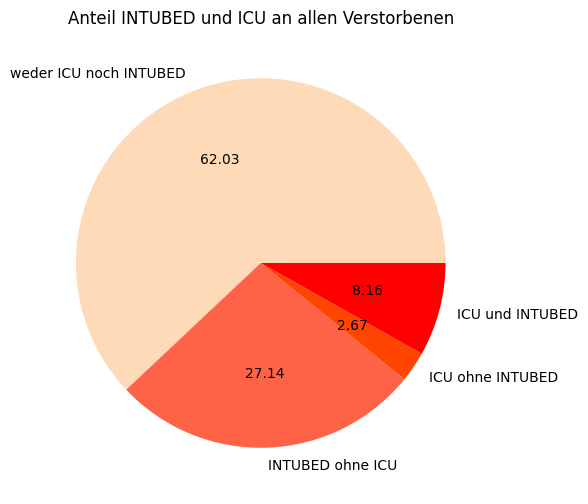

In [6]:
series.plot.pie(labels=["weder ICU noch INTUBED","INTUBED ohne ICU","ICU ohne INTUBED","ICU und INTUBED"],
    colors=["peachpuff","tomato","orangered","r"],autopct="%.2f",
    fontsize=10,figsize=(6, 6),title="Anteil INTUBED und ICU an allen Verstorbenen")

Wir sehen, dass über 60% der Verstorbenen weder intubiert wurden noch auf der Intensivstation waren.
Etwa 35% der Verstorbenen wurden intubiert. 

In [7]:
series=df[df.ICU==1].groupby(['DIED','INTUBED']).size()
series

DIED  INTUBED
0     0.0        5425
      1.0        3042
1     0.0        1956
      1.0        5985
dtype: int64

<Axes: title={'center': 'Anteil DIED und INTUBED an allen Intensivpatienten'}>

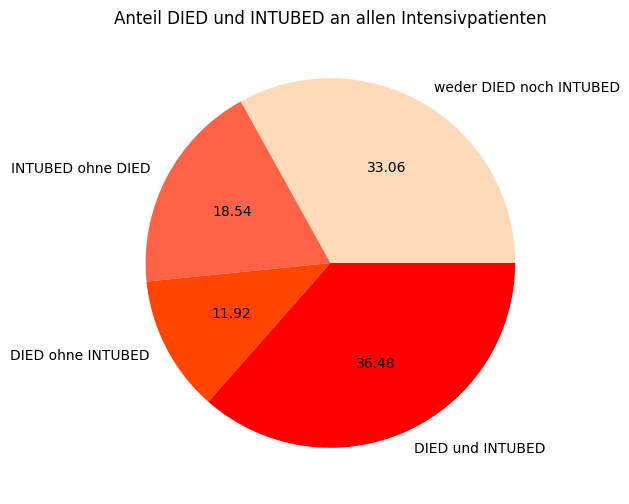

In [8]:
series.plot.pie(labels=["weder DIED noch INTUBED","INTUBED ohne DIED", "DIED ohne INTUBED", "DIED und INTUBED"],
    colors=["peachpuff","tomato","orangered","r"],autopct="%.2f",
    fontsize=10,figsize=(6, 6),title="Anteil DIED und INTUBED an allen Intensivpatienten")

Umgekehrt ist hingegen etwa die Hälfte aller Intensivpatienten auch verstorben. Mehr als die Hälfte aller Intensivpatienten wurde intubiert.

In [9]:
series=df[df.INTUBED==1].groupby(['DIED','ICU']).size()
series

DIED  ICU
0     0.0     4011
      1.0     3042
1     0.0    19898
      1.0     5985
dtype: int64

<Axes: title={'center': 'Anteil DIED und ICU an allen Intubierten'}>

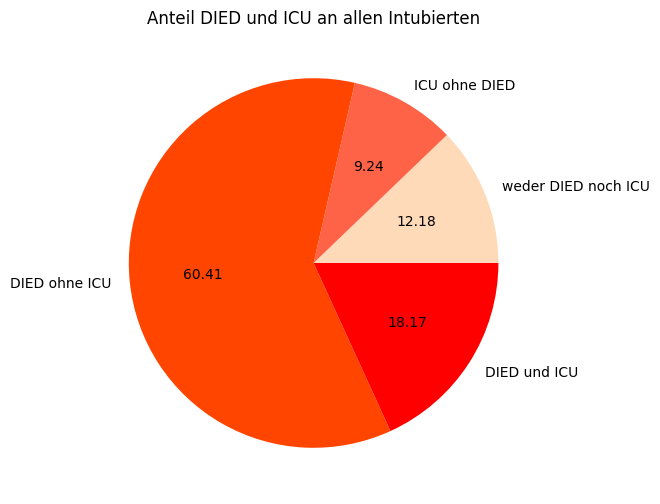

In [10]:
series.plot.pie(labels=["weder DIED noch ICU","ICU ohne DIED", "DIED ohne ICU" , "DIED und ICU"],
    colors=["peachpuff","tomato","orangered","r"],autopct="%.2f",
    fontsize=10,figsize=(6, 6),title="Anteil DIED und ICU an allen Intubierten")

Von den Intubierten sind fast 80% auch gestorben. Knapp 30% waren auf der Intensivstation. 

Text(0.5, 0.85, 'Anteil der gesichert Covid-Erkrankten an')

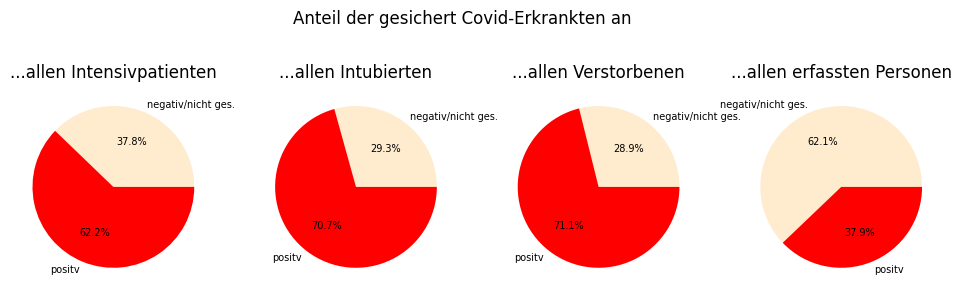

In [11]:
df1 = pd.DataFrame([df[df.ICU==1].groupby('COV').size(),df[df.INTUBED==1].groupby('COV').size(),
                    df[df.DIED==1].groupby('COV').size(),df.groupby('COV').size()])
df1.T.plot.pie(subplots=True,figsize=(12,5),title=['...allen Intensivpatienten','...allen Intubierten','...allen Verstorbenen',
                                                  '...allen erfassten Personen'],legend=False,autopct='%1.1f%%',
              labels=['negativ/nicht ges.','positv'],ylabel='',fontsize=7,colors=['blanchedalmond','red'])
plt.suptitle('Anteil der gesichert Covid-Erkrankten an',y=0.85)


Wir schauen uns nun an, wie eine gesicherte Covid-Diagnose mit den Zielvariablen zusammenhängt. Auffällig ist, dass der Anteil der Personen
mit einer gesicherten Covid-Diagnose bei allen drei Zielvariablen deutlich höher ist als bei allen erfassten Personen.

Text(0.5, 0.9, 'Von allen gesichert Covid-Erkrankten waren')

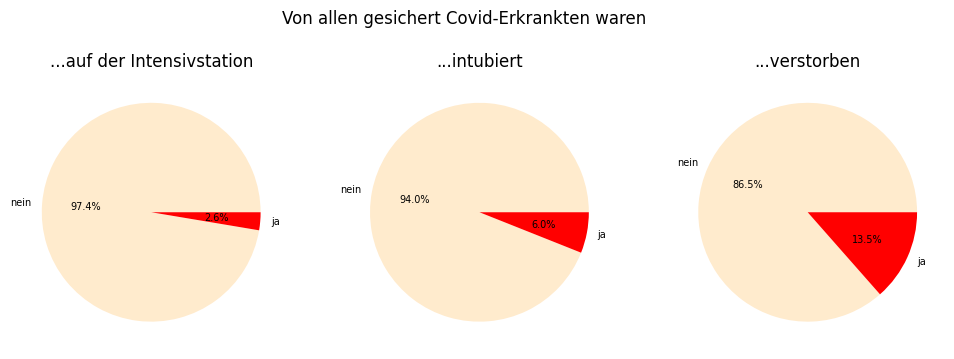

In [12]:
df1 = pd.DataFrame([df[df.COV==1].groupby('ICU').size(),df[df.COV==1].groupby('INTUBED').size(),
                    df[df.COV==1].groupby('DIED').size()])
df1.T.plot.pie(subplots=True,figsize=(12,5),title=['...auf der Intensivstation','...intubiert','...verstorben'
                                                  ],legend=False,autopct='%1.1f%%',
              labels=['nein','ja'],ylabel='',fontsize=7,colors=['blanchedalmond','red'])
plt.suptitle('Von allen gesichert Covid-Erkrankten waren',y=0.9)

Umgekehrt ist hingegen nur ein kleiner Prozentsatz der gesichert Erkrankten auf der Intensivstation gewesen. Intubiert wurden 6%,
verstorben sind ca. 14%. 

In [13]:
df.DATE_DIED=df.DATE_DIED.replace('9999-99-99',np.nan)
df.DATE_DIED=pd.to_datetime(df.DATE_DIED, format='%d/%m/%Y')

Text(0.5, 1.0, 'Anzahl der Verstorbenen im Zeitverlauf')

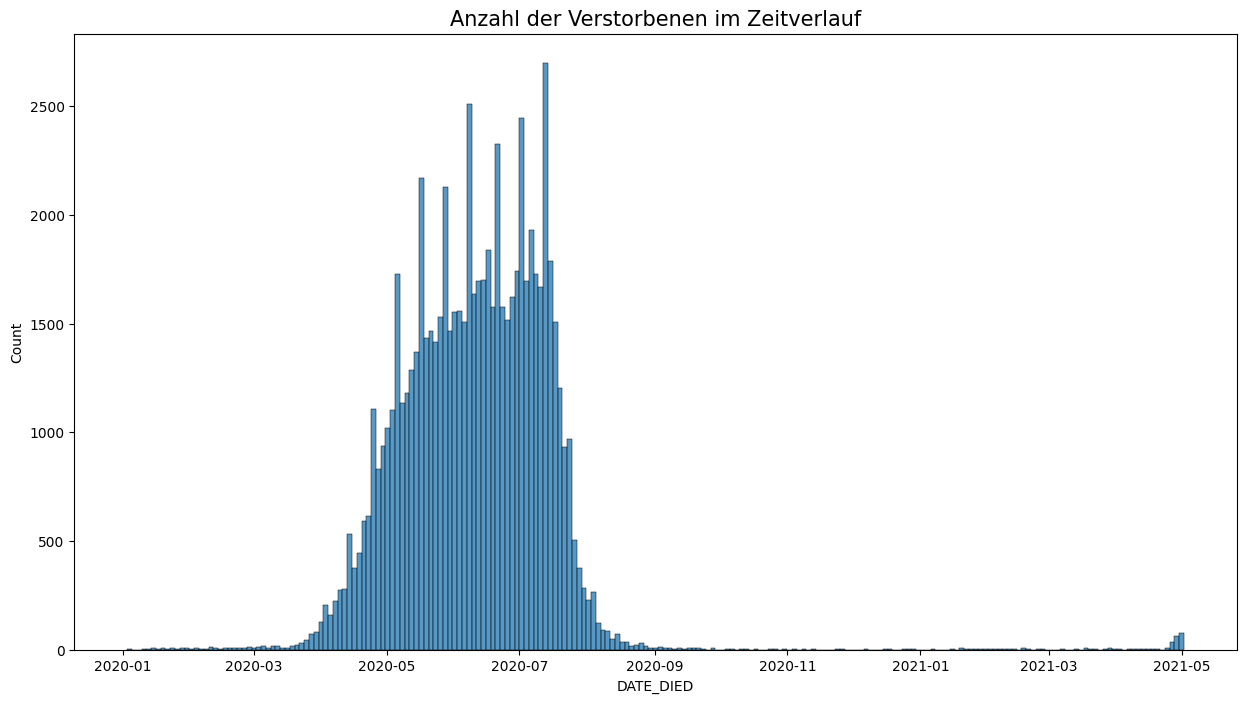

In [14]:
plt.figure(figsize=(15,8))
sns.histplot(data=df, x="DATE_DIED")
plt.title('Anzahl der Verstorbenen im Zeitverlauf', fontsize = 15)

Die Anzahl der Verstorbenen steigt mit dem Einsetzen der Pandemie im März 2020 an. Da die Daten nur bis August 2020 gepflegt wurden,
reißt hier das Histogramm abrupt ab. Im besagten Zeitraum waren noch keine Impfstoffe verfügbar. Die Kurve wächst in der Anfangsphase wie
erwartet exponentiell an und flach dann - vermutlich bedingt durch die Schutzmaßnahmen - ab. Der Grund für die Spikes ist unklar. Es könnte sein,
dass bestimmte Einrichtungen nur in bestimmten Intervallen (z.B. wöchentlich) Daten erfasst bzw. übermittelt haben. 

Text(0.5, 1.0, 'INTUBED')

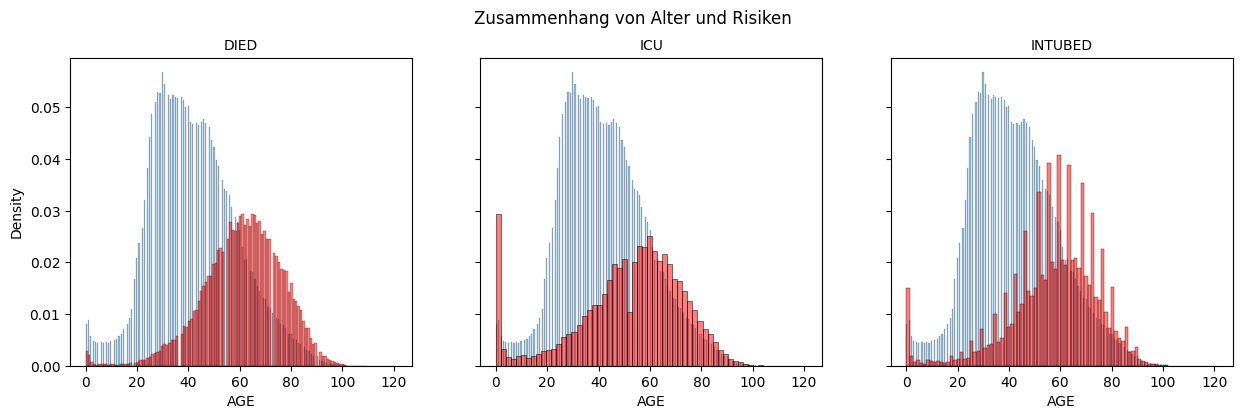

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 4), sharey=True)
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Zusammenhang von Alter und Risiken", fontsize=12, y=1)

sns.histplot(ax=axes[0], data=df,x="AGE", stat='density',alpha=0.5)
sns.histplot(ax=axes[0],data=df[df.DIED==1], x="AGE",stat='density',color='red',alpha=0.5)
axes[0].set_title('DIED',fontsize=10)

sns.histplot(ax=axes[1], data=df,x="AGE", stat='density',alpha=0.5)
sns.histplot(ax=axes[1],data=df[df.ICU==1], x="AGE",stat='density',color='red',alpha=0.5)
axes[1].set_title('ICU',fontsize=10)

sns.histplot(ax=axes[2], data=df,x="AGE", stat='density',alpha=0.5)
sns.histplot(ax=axes[2],data=df[df.INTUBED==1], x="AGE",stat='density',color='red',alpha=0.5)
axes[2].set_title('INTUBED',fontsize=10)



Wir betrachten den Einfluss des Alters auf die Zielvariablen. Es ist deutlich zu erkennen, dass die Gruppe der Verstorbenen eine
nach rechts verschobene Altersverteilung besitzt. Dies gilt auch für die Intensivpatienten und die Intubierten. Alter scheint also ein
wesentlicher Prädiktor für das Risiko eines schweren Verlaufs zu sein. Bei den Intensivpatienten ist der hohe Prozentsatz an Neugeborenen
auffällig. Der Grund für die Behandlung auf der Intensivstation könnte die besondere Anfälligkeit von Neugeborenen sein, deren Immunsystem
noch nicht ausgeprägt ist. Es ist auch denkbar, dass andere Faktoren als Covid hier eine Rolle spielen, etwa andere pädiatrische Erkrankungen
oder besondere Vorsichtsmaßnahmen. Die ausgeprägte Spike-Struktur bei der Altersverteilung der Intubierten ist unklarer Herkunft.

In [16]:
df.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU', 'DIED',
       'COV'],
      dtype='object')

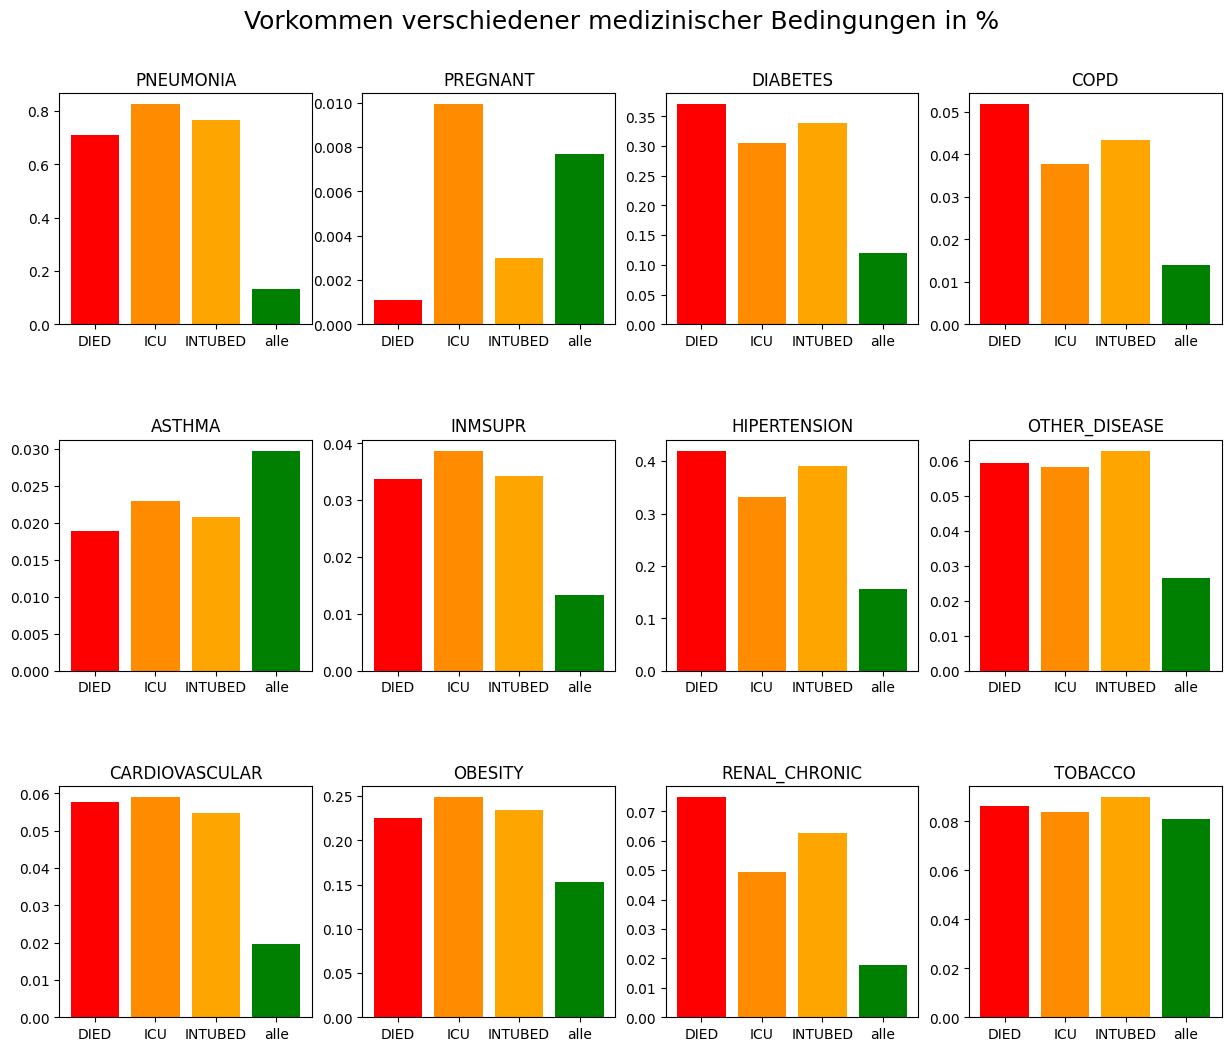

In [17]:
selected_columns=['PNEUMONIA','PREGNANT','DIABETES','COPD','ASTHMA','INMSUPR','HIPERTENSION','OTHER_DISEASE',
                 'CARDIOVASCULAR','OBESITY','RENAL_CHRONIC','TOBACCO']

def make_percentages(column):

    percentages=[len(df[(df[column]==1)&(df.DIED==1)])/len(df[df.DIED==1]),
                 len(df[(df[column]==1)&(df.ICU==1)])/len(df[df.ICU==1]),
                 len(df[(df[column]==1)&(df.INTUBED==1)])/len(df[df.INTUBED==1]),
                 len(df[df[column]==1])/len(df)]
    return percentages

x=['DIED','ICU','INTUBED','alle']

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Vorkommen verschiedener medizinischer Bedingungen in %", fontsize=18, y=0.95)


for column, ax in zip(selected_columns, axs.ravel()):
    ax.bar(x,make_percentages(column),color=["red","darkorange","orange","green"])
    ax.set_title(column)

plt.show()

Wir betrachten nun den Zusammenhang verschiedener medizinischer Bedingungen mit den Zielvariablen. Dazu vergleichen wir, bei wieviel Prozent
aller Verstorbenen, aller Intensivpatienten und aller Intubierten eine bestimmte medizinische Bedingung vorliegt. Außerdem vergleichen wir
diese Prozentzahlen mit dem allgemeinen Vorkommen der jeweiligen Bedingungen bei allen betrachteten Individuen. 

Auffällig ist, dass Lungenentzündungen (Pneumonien) 7-8 mal so häufig unter den Risikopatienten vorkommen. Die Zahlen liegen hier im Bereich
70-80%. Zu vermuten ist, dass die Pneumonie hier der entscheidende Faktor war, der zum Versterben, zur Behandlung auf der Intensivstation oder
zur Intubation geführt hat. Bluthochdruck und Diabetes sind unter den Risikopatienten etwa 3-4 mal so häufig ausgeprägt, insgesamt zwischen 30
und 40%. Übergewicht war unter den Risikopatienten etwas häufiger, mit 15% der gesamten Individuen jedoch immer noch insgesamt recht häufig.
Auch kardiovaskuläre Erkrankungen, chronische Nierenerkrankungen, Immunsuppression und andere Erkrankungen waren unter den Risikopatienten
etwa 2-4 mal so häufig ausgeprägt, allerdings kamen diese medizinischen Bedingungen insgesamt nicht sehr häufig vor. 

Aufällig ist auch, dass Tabakkonsum unter den Risikopatienten nicht häufiger ausgeprägt ist, so dass dieser als Faktor keinen Einfluss
zu haben scheint. Asthmaerkrankte finden sich sogar leicht weniger unter Risikopatienten als unter allen Individuen. Eventuell könnte hier
hier eine besondere individuelle Vorsicht eine Rolle gespielt haben oder auch die protektive Wirkung von Inhalationssprays, die tatsächlich in der Forschung diskutiert wurde. Eine Schwangerschaft ist nur unter den Intensivpatienten etwas
häufiger als unter allen Betrachteten. Unter den Verstorbenen und Intubierten gibt deutlich weniger Schwangere. Da Schwangere tendenziell
eher jünger sind und die Risiken mit dem Alter ansteigen, ist dies schlüssig. Die Gründe für eine intensivmedizinische Behandlung könnten
bei Schwangeren mit gynäkologischen Faktoren zu tun haben, die unabhängig von der Covid-Pandemie sind.

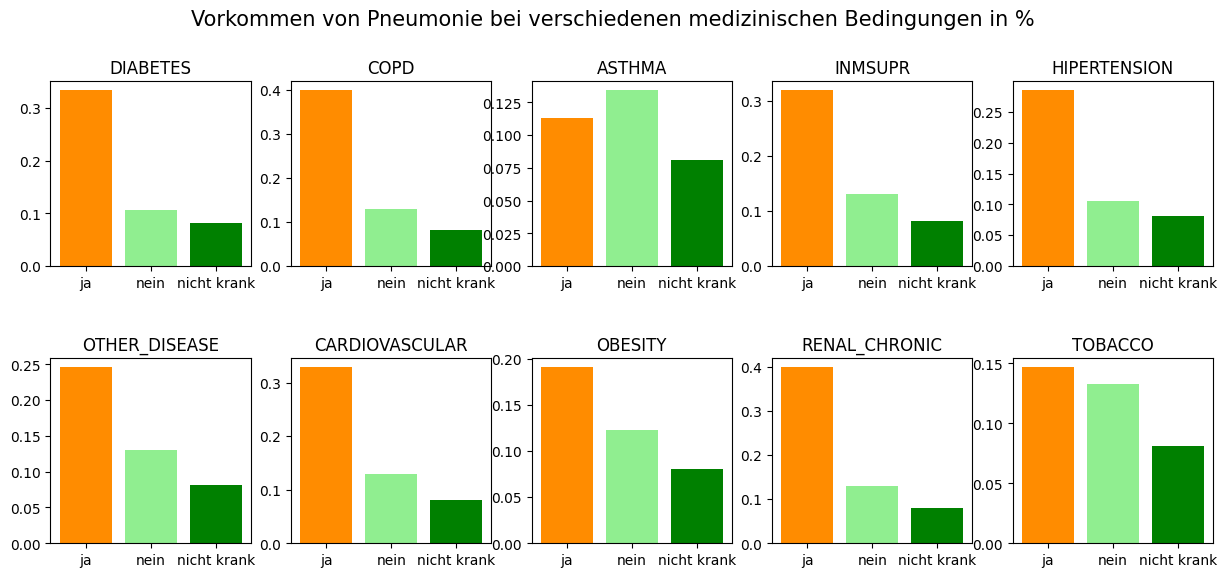

In [18]:
selected_columns1=['DIABETES','COPD','ASTHMA','INMSUPR','HIPERTENSION','OTHER_DISEASE',
                 'CARDIOVASCULAR','OBESITY','RENAL_CHRONIC','TOBACCO']

df_temp=df[(df.DIABETES==0)&(df.COPD==0)&(df.ASTHMA==0)&(df.INMSUPR==0)&(df.HIPERTENSION==0)&(df.OTHER_DISEASE==0)&
       (df.CARDIOVASCULAR==0)&(df.OBESITY==0)&(df.RENAL_CHRONIC==0)&(df.TOBACCO==0)]

m = len(df_temp[df_temp.PNEUMONIA==1])/len(df_temp)

def make_percentages(column):

    percentages=[len(df[(df[column]==1)&(df.PNEUMONIA==1)])/len(df[df[column]==1]),
                 len(df[(df[column]==0)&(df.PNEUMONIA==1)])/len(df[df[column]==0]),
                 m]
    return percentages

x=['ja','nein','nicht krank']

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Vorkommen von Pneumonie bei verschiedenen medizinischen Bedingungen in %", fontsize=15, y=1)


for column, ax in zip(selected_columns1, axs.ravel()):
    ax.bar(x,make_percentages(column),color=["darkorange","lightgreen","green"])
    ax.set_title(column)

plt.show()

Die vorherige Analyse gibt Anlass, das Verhältnis der Lungenentzündung zu anderen medizinischen Bedingungen etwas genauer zu betrachten. Es
fällt auf, dass Lungenentzündungen bei fast allen medizinischen Bedingungen außer beim Asthma und beim Tabakkonsum etwa 2-4 mal
häufiger auftreten als beim Nicht-Vorliegen der entsprechenden Bedingung. Unter denjenigen, die von keiner medinizischen
Bedingung betroffen sind, ist der Anteil der Individuen mit Lungenentzündung am niedrigsten. 

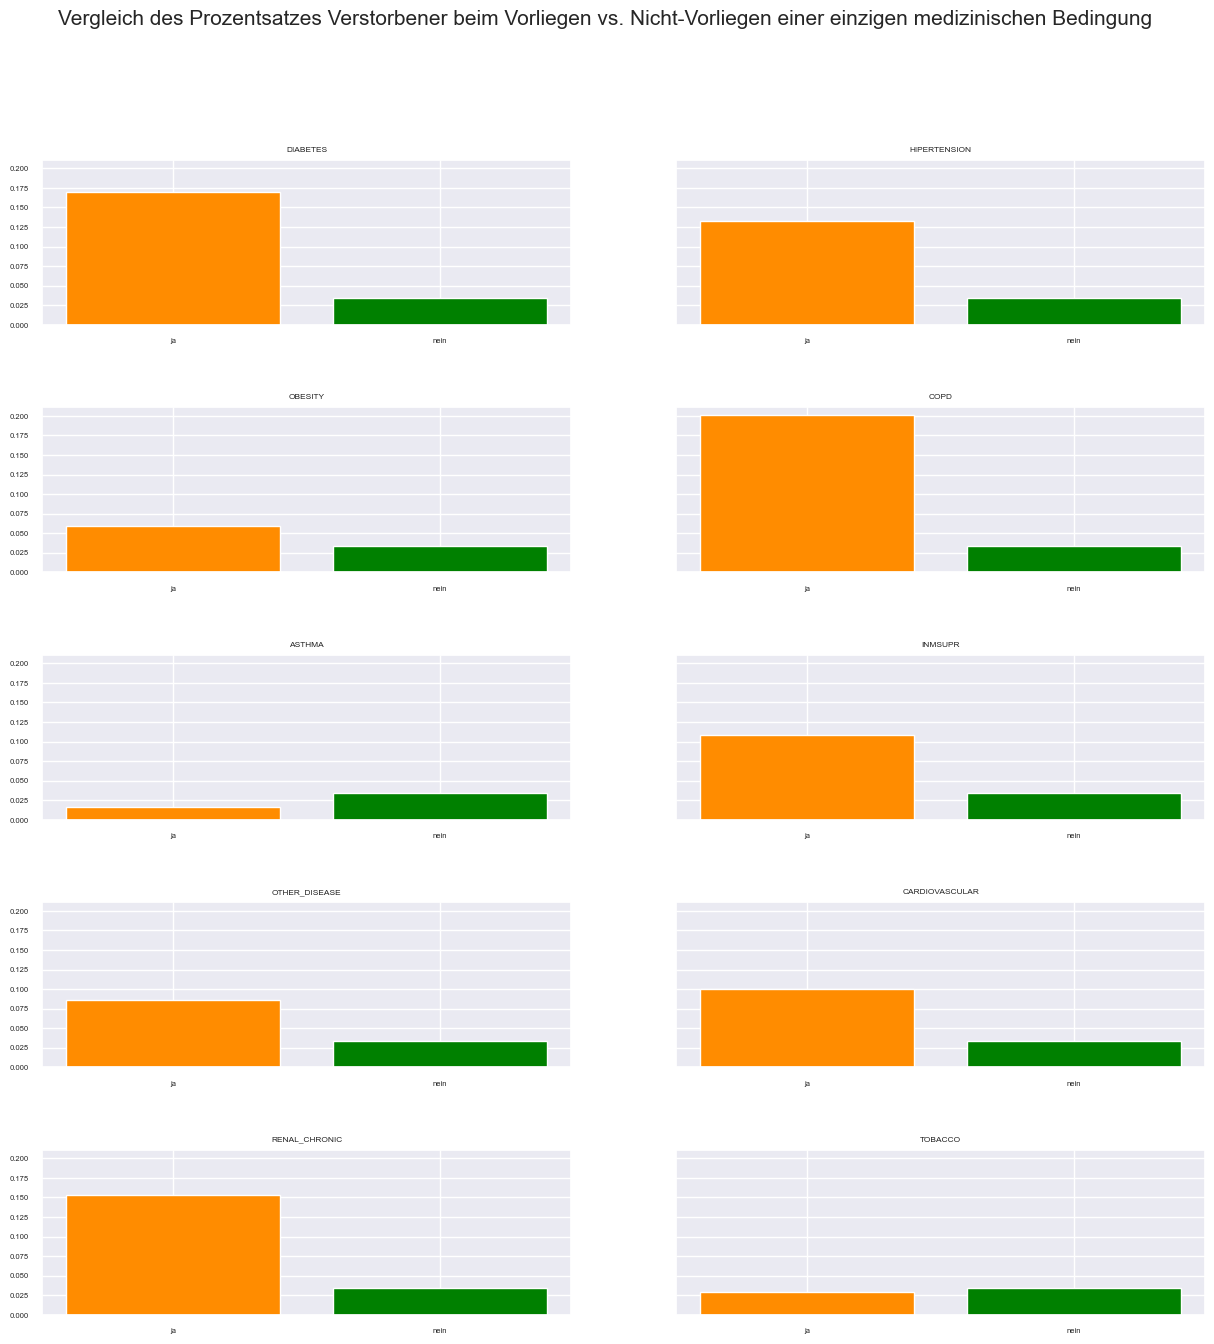

In [34]:
selected_columns2=['DIABETES','HIPERTENSION','OBESITY','COPD','ASTHMA','INMSUPR','OTHER_DISEASE',
                 'CARDIOVASCULAR','RENAL_CHRONIC','TOBACCO']

fig, axs = plt.subplots(nrows=5, ncols=2,sharey=True,figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Vergleich des Prozentsatzes Verstorbener beim Vorliegen vs. Nicht-Vorliegen einer einzigen medizinischen Bedingung", fontsize=15)


def make_percentages(col):
    selected_columns3=selected_columns2.copy()
    selected_columns3.remove(col)
    df1=df.loc[df[selected_columns3].sum(axis=1)==0]
    p=len(df1[(df1.DIED==1)&(df1[col]==1)])/len(df1[df1[col]==1])
    q=len(df1[(df1.DIED==1)&(df1[col]==0)])/len(df1[df1[col]==0])
    return [p,q]
    
x=['ja','nein']
    
for column, ax in zip(selected_columns2, axs.ravel()):
    ax.bar(x,make_percentages(column),color=["darkorange","green"])
    ax.set_title(column)

plt.show()

Das Vorliegen vieler Erkrankungen ist stark mit dem Vorliegen anderer Erkrankungen gekoppelt. Um diesen Effekt auszuschalten,
betrachten wir nur die Individuen, die von einer einzigen medizinischen Bedingung betroffen sind und beobachten, ob das Vorliegen 
dieser einzelnen Bedingung mit einem höheren Sterberisiko verknüpft ist. Dies ist am deutlichsten bei der COPD, einer chronischen
Lungenerkrankung, der Fall. Aber auch bei Diabetes, Bluthochdruck und chronischen Nierenerkankungen alleine ist das Sterberisiko
erhöht. Auch hier fällt wieder auf, dass Tabakkonsum keinen Einfluss auf das Sterberisiko besitzt und Asthma sogar mit einem leicht niedrigeren
Risiko verknüpft ist. Auch Übergewicht alleine scheint eher einen geringen Einfluss zu haben. 

Text(0.5, 0.9, 'Von allen Pneumonie-Patienten waren')

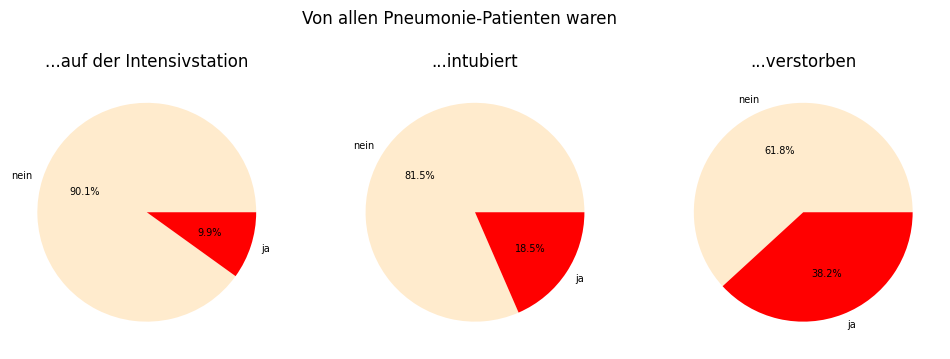

In [23]:
df1 = pd.DataFrame([df[df.PNEUMONIA==1].groupby('ICU').size(),df[df.PNEUMONIA==1].groupby('INTUBED').size(),
                    df[df.PNEUMONIA==1].groupby('DIED').size()])
df1.T.plot.pie(subplots=True,figsize=(12,5),title=['...auf der Intensivstation','...intubiert','...verstorben'
                                                  ],legend=False,autopct='%1.1f%%',
              labels=['nein','ja'],ylabel='',fontsize=7,colors=['blanchedalmond','red'])
plt.suptitle('Von allen Pneumonie-Patienten waren',y=0.9)

Wir führen die Analyse der Pneumonie-Patienten fort. Hier fällt auf, dass ca. 40% dieser Patienten verstorben sind. 

Text(0.5, 0.85, 'Anteil der Pneumonie-Patienten an')

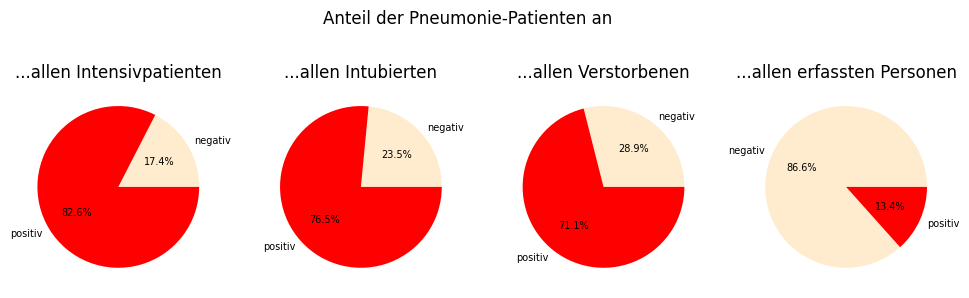

In [24]:
df1 = pd.DataFrame([df[df.ICU==1].groupby('PNEUMONIA').size(),df[df.INTUBED==1].groupby('PNEUMONIA').size(),
                    df[df.DIED==1].groupby('PNEUMONIA').size(),df.groupby('PNEUMONIA').size()])
df1.T.plot.pie(subplots=True,figsize=(12,5),title=['...allen Intensivpatienten','...allen Intubierten','...allen Verstorbenen',
                                                  '...allen erfassten Personen'],legend=False,autopct='%1.1f%%',
              labels=['negativ','positiv'],ylabel='',fontsize=7,colors=['blanchedalmond','red'])
plt.suptitle('Anteil der Pneumonie-Patienten an',y=0.85)


Noch deutlich wird das Bild, wenn man sich den Anteil der Pneumonie-Patienten an allen Risikopatienten anschaut. Über 70% der Verstorbenen
hatten eine Lungenentzündung, mehr als 75% aller Intubierten und sogar mehr als 80% aller Intensivpatienten. Diese Zahlen legen den Schluss nahe,
dass die Lungenentzündung, die ja in der Regel eine akute medizinische Bedingung im Vergleich zu den anderen, eher chronischen
Bedingungen wie Diabetes, Bluthochdruck etc. darstellt, das Bindeglied ist, das von einer Reihe von chronischen Vorerkrankungen zu einem
akuten Verlauf führt. 

<Axes: xlabel='AGE', ylabel='Density'>

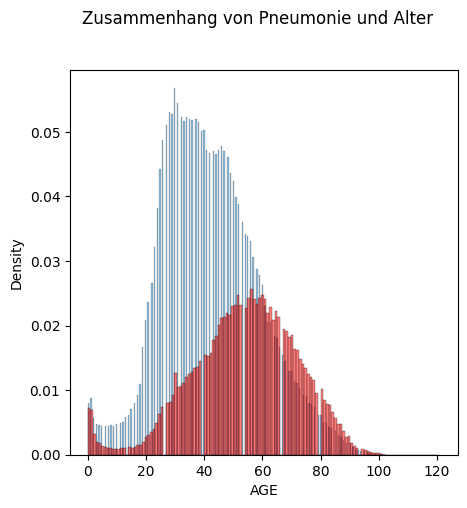

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(5, 5), sharey=True)
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Zusammenhang von Pneumonie und Alter", fontsize=12, y=1)

sns.histplot(data=df,x="AGE", stat='density',alpha=0.5)
sns.histplot(data=df[df.PNEUMONIA==1], x="AGE",stat='density',color='red',alpha=0.5)


Demzufolge entspricht die Altersverteilung der Patienten mit Lungenentzündung der Altersverteilung der Risikopatienten.

In [26]:
#Neue Spalte, die Anzahl medizinischer Bedingungen angibt
df['nmc']=df[selected_columns].sum(axis=1)
#df['nmc']=24-df['nmc']

In [27]:
selected_columns

['PNEUMONIA',
 'PREGNANT',
 'DIABETES',
 'COPD',
 'ASTHMA',
 'INMSUPR',
 'HIPERTENSION',
 'OTHER_DISEASE',
 'CARDIOVASCULAR',
 'OBESITY',
 'RENAL_CHRONIC',
 'TOBACCO']

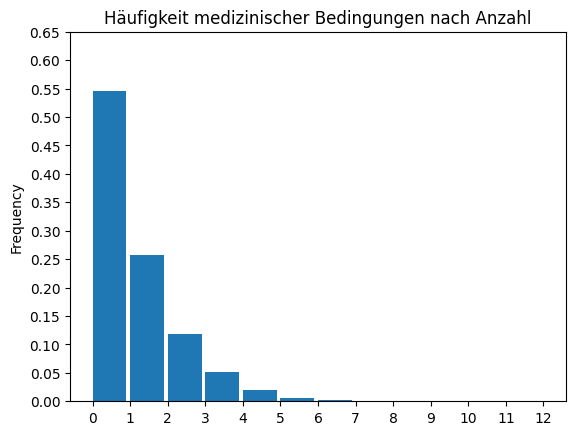

In [28]:
df.nmc.plot.hist(bins=12,density=True,width=0.9)
plt.xticks([i for i in range(0,13)])
plt.yticks([0.05*i for i in range(0,14)])
plt.title("Häufigkeit medizinischer Bedingungen nach Anzahl")
plt.show()

Wir betrachten nun noch den Zusammenhang der medizinischen Bedingungen untereinander. Bei etwa 20% aller Individuen lagen zwei oder 
mehr medizinische Bedingungen vor. Bei etwas weniger als 10% lagen sogar drei oder mehr medizinische Bedingungen vor.

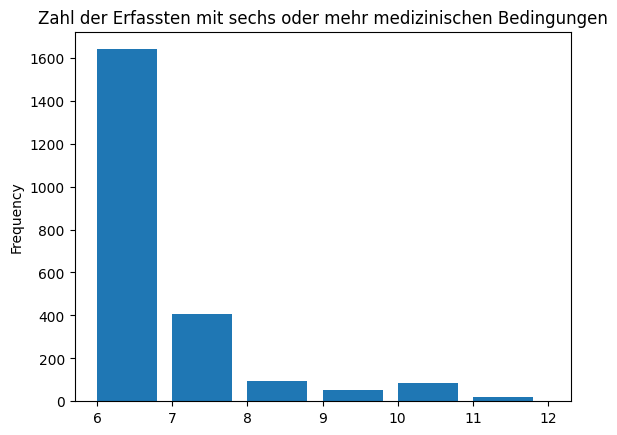

In [29]:
df.nmc[df.nmc>5].plot.hist(bins=6,width=0.8)
#plt.xticks([i for i in range(6,14)])
#plt.yticks([0.05*i for i in range(0,14)])
plt.title("Zahl der Erfassten mit sechs oder mehr medizinischen Bedingungen")
plt.show()

Es gab hingegen kaum Individuen, die mehr als sechs medizinische Bedingungen aufwiesen. 

Text(0.5, 1.0, 'Prozentsatz der Verstorbenen, Intensivpatienten und Intubierten nach Anzahl medizinischer Bedingungen')

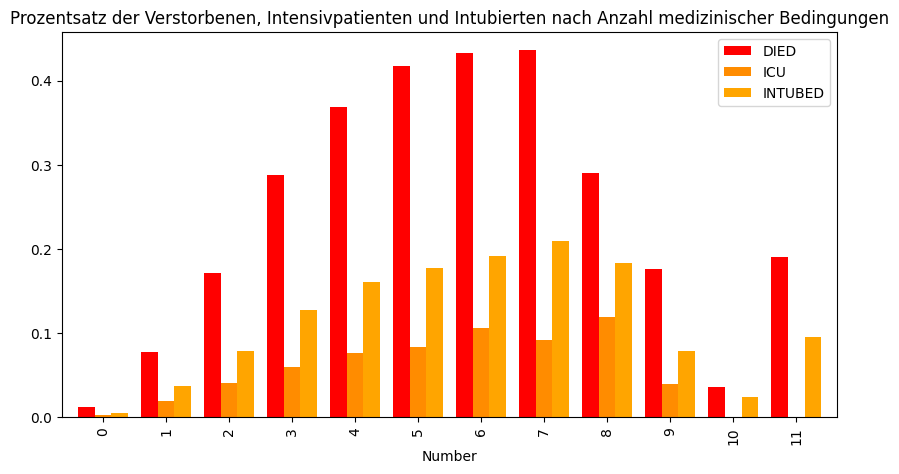

In [30]:
def make_percentages(n):

    percentages={'Number':n,'DIED':len(df[(df.nmc==n)&(df.DIED==1)])/len(df[df.nmc==n]),
                 'ICU':len(df[(df.nmc==n)&(df.ICU==1)])/len(df[df.nmc==n]),
                 'INTUBED':len(df[(df.nmc==n)&(df.INTUBED==1)])/len(df[df.nmc==n])}
    return percentages

x=['DIED','ICU','INTUBED']

df1 = pd.DataFrame(columns=['Number', 'DIED', 'ICU', 'INTUBED']) 

for i in range(0,12):
    df1.loc[len(df1)]=make_percentages(i)


df1.plot(x='Number',kind='bar',color=["red","darkorange","orange"],width=0.8,figsize=(10,5))
    #plt.set_title(number)

plt.title("Prozentsatz der Verstorbenen, Intensivpatienten und Intubierten nach Anzahl medizinischer Bedingungen")

Betrachtet man den Prozentsatz Verstorbener, Intubierter oder intensivmedizinisch Behandelter jeweils unter den Personen,
die dieselbe Anzahl medizinischer Bedingungen aufweisen, wird folgendes ersichtlich: Der Anteil Verstorbener steigt mit der Anzahl medizinischer Bedingungen stark an, bis er über 40% liegt, wenn sechs oder sieben Bedingungen vorliegen. Auch der Anteil
Intubierter steigt nach diesem Muster bis zum Vorliegen von sieben Bedingungen auf über 20% an. Beim Anteil der Intensivpatienten ist ein ähnliches Muster sichtbar. Liegen mehr als sieben Bedingungen vor, flachen die Anteile wieder ab. Dies könnte damit zusammenhängen, dass es in diesem Bereich nicht mehr genügend Individuen gibt, um zu repräsentativen Anteilen zu gelangen und statistische Schwankungen zu groß werden. Insgesamt scheint Multimorbidität also ein wichtiger Risikofaktor für einen schweren Verlauf zu sein. 

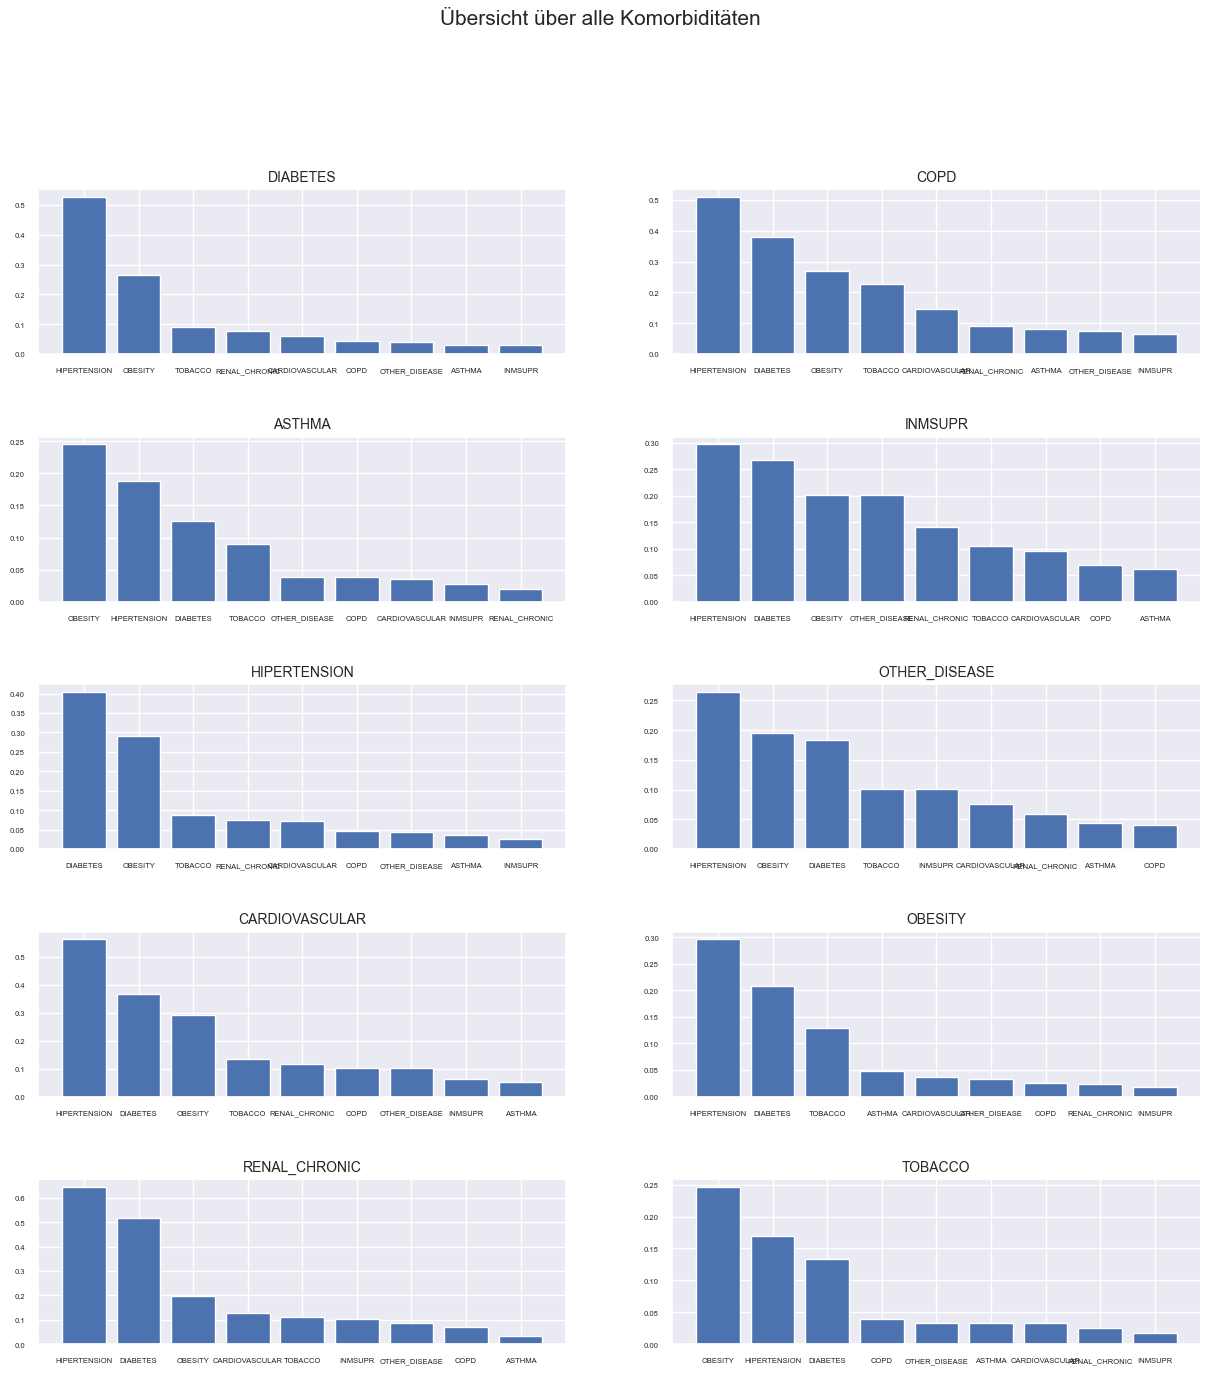

In [36]:
def make_percentages1(column):
    dic={}
    for comorb in selected_columns1: 
        dic[comorb]=len(df[(df[column]==1)&(df[comorb]==1)])/len(df[df[column]==1])
    
    dic.pop(column)
    dic = dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))
    return dic


fig, axs = plt.subplots(nrows=5, ncols=2,figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Übersicht über alle Komorbiditäten", fontsize=15, y=1)


for column, ax in zip(selected_columns1, axs.ravel()):
    ax.bar(make_percentages1(column).keys(),make_percentages1(column).values())
    ax.set_title(column,fontsize=10)

plt.show()

Daraus ergibt sich die Frage, welche medizinischen Bedingungen bzw. Erkrankungen besonders oft zusammen auftreten. Da die Sonderstellung
der Lungenentzündung als meist akuter Erkrankung schon untersucht wurde, wird diese hier nicht mehr betrachtet. Zu den verbleibenden
medizinischen Bedingungen werden alle Komorbiditäten bzw. Kofaktoren nach Häufigkeit betrachtet. Es fällt auf, dass die Trias aus Diabetes,
Bluthochdruck und Übergewicht bei allen anderen Bedingungen immer die ersten drei Plätze einnehmen. Dies entspricht allgemeinen
medizinischen Beobachtungen. 
Tatsächlich wird für die Kombination aus Diabetes, Bluthochdruck, Übergewicht und hohem Cholesterinspiegel
(der in den Daten nicht betrachtet wurde) die Bezeichnung "Metabolisches Syndrom" verwendet. Es ist in der medizinischen
Forschungsliteratur bekannt, dass das Vorliegen eines Metabolischen Syndroms das Risiko eines schweren Covid-Verlaufs deutlich erhöht (Quelle siehe Praktikumsbericht). 

Text(0.5, 1.0, 'Korrelationsmatrix der Features')

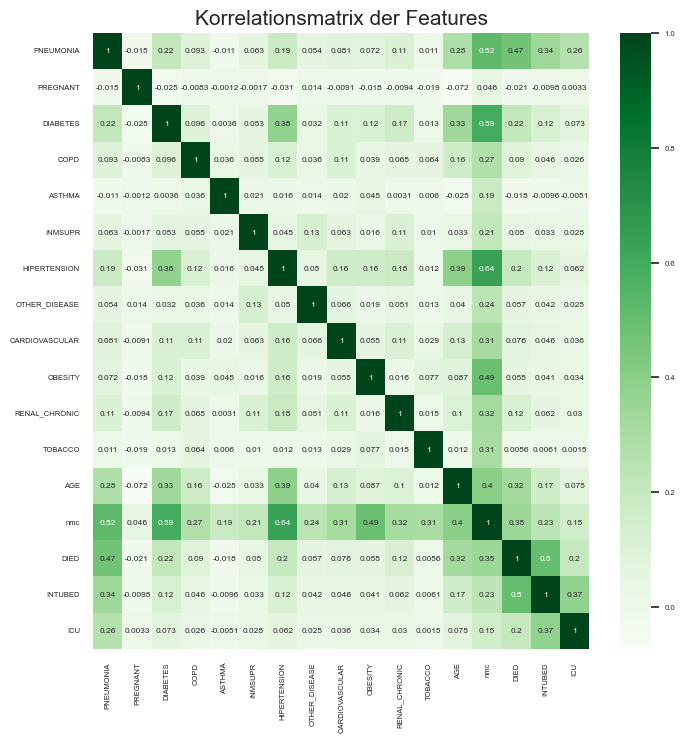

In [32]:
selection =selected_columns+['AGE','nmc','DIED','INTUBED','ICU']
matrix = df[selection].corr()
#matrix=abs(matrix)

sns.set(rc = {'figure.figsize':(8, 8)})
sns.set(font_scale=0.5)
sns.heatmap(matrix, cmap="Greens", annot=True).set_title("Korrelationsmatrix der Features",fontsize=15)


Wir betrachten zum Schluss die Absolutbeträge der Korrelationen aller Faktoren in der Zusammenschau. Hohe Korrelationen gibt es zwischen dem Alter,
der Anzahl der Erkrankungen, der Trias Diabetes/Bluthochdruck/Übergewicht, der Pneumonie und den Zielvariablen. Ältere Menschen leiden
also tendenziell unter einer höheren Anzahl medizinischer Vorbedingungen, zu denen tendenziell häufig das Metabolische Syndrom gehört. 
In dieser Kombination kommt es häufig zu einem schwereren Verlauf mit Lungenentzündung, der dann auch häufiger zum Versterben bzw.
zur Notwendigkeit einer Beatmung und/oder intensivmedizinischen Behandlung führt.

Die exploratische Analyse scheint damit bekannte Zusammenhänge zu bestätigen: besonders gefährdet sind ältere Menschen und/oder solche 
    mit vielen und/oder schweren Vorerkrankungen. Es ist schließlich noch darauf hinzuweisen, dass aus den betrachteten Zusammenhängen keine
    Kausalbeziehungen abgeleitet werden können. Dies ist umso weniger der Fall, als dass die Daten reine Momentaufnahmen sind, die 
    keine zeitliche Verläufe und keine feindifferenzierte Abstufung der Merkmale (wie etwa verschiedene Grade der Lungenentzündung)
    erfassen. So kann z.B. keine Aussage darüber getroffen werden, ob das Vorliegen einer Lungenentzündung zur Behandlung auf der
    Intensivstation geführt hat oder diese erst während einer intensivmedizinischen Behandlung aufgetreten ist. 